# Mini Project: Identifikasi Arsitektur Big Data “Gojek (GoRide/GoFood)” + Simulasi Pipeline Data dengan Python
Jangan Lupa di Copy Paste ya!

> **Catatan Optimisasi**: Notebook ini telah dimodifikasi untuk menggunakan **Teknologi Modern High-Performance** (PyArrow, Parquet, Dask) agar dapat memproses **220 Juta Baris Data** dengan cepat dan hemat memori, sesuai permintaan.

# Notebook ini adalah template praktikum
Output yang dikumpulkan berupa:

1.   Laporan singkat (2–4 halaman / 6–10 slide): arsitektur Big Data perusahaan (5 komponen)
2.   Notebook Python (.ipynb): simulasi ingestion → storage → processing → visualization.



In [1]:
import os
import sys
import time
import datetime
import random
import gc
import shutil
import json
from collections import deque
from datetime import timedelta

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import dask.dataframe as dd
import psutil
from tqdm.auto import tqdm

%pip install tqdm

# Setting Environment
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "synthetic_data_optimized")
RAW_DIR = os.path.join(DATA_DIR, "data_lake", "raw")
CURATED_DIR = os.path.join(DATA_DIR, "data_lake", "curated")
REPORT_DIR = os.path.join(DATA_DIR, "reports")

for d in [RAW_DIR, CURATED_DIR, REPORT_DIR]:
    os.makedirs(d, exist_ok=True)

print("Ready. Base dir:", BASE_DIR)
print("Data Storage:", DATA_DIR)

C:\Users\josgi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Ready. Base dir: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2
Data Storage: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized


## 1) Sumber Data (Data Sources) — Contoh pada Gojek

Kita modelkan 5 sumber data utama:

1. **Event aplikasi**  
   - order_created, driver_assigned, driver_accepted, order_completed, order_cancelled  
2. **GPS / telemetry driver**  
   - lokasi (lat, lon), kecepatan, timestamp  
3. **Log sistem & aplikasi**  
   - error_code, latency_ms, service_name  
4. **Data pembayaran** (GoPay), promo/voucher  
   - metode bayar, nilai transaksi, promo_id  
5. **Ulasan/rating & complaint**  
   - rating, komentar, kategori complaint  

Di industri, data ini biasanya masuk sebagai event JSON (streaming) + batch (rekap harian/keuangan).

Sekaligus mensimulasikannya menggunakan Generated Data:

- `orders_raw` (event order)
- `gps_raw` (telemetry)
- `logs_raw` (system logs)
- `payments_raw`
- `reviews_raw`

**Note Optimisasi:** Data akan di-generate langsung ke Disk (Parquet) untuk menghindari Out-Of-Memory.

In [2]:
# --- CONFIGURATION ---
N_ORDERS = 30_000_000
N_DRIVERS = 50_000
N_GPS    = 15_000_000
N_LOGS   = 40_000_000
CHUNK_SIZE = 1000000

START_DATE = datetime.datetime(2021, 1, 20)
END_DATE = datetime.datetime(2026, 1, 20)
TOTAL_SECONDS = int((END_DATE - START_DATE).total_seconds())

# Area: Kalimantan Barat
LAT_MIN, LAT_MAX = -3.05, 2.10
LON_MIN, LON_MAX = 108.50, 114.10

print(f"Target Scale: {N_ORDERS/1e6:.0f}M Orders, {N_GPS/1e6:.0f}M GPS Points")
print(f"Location: Kalimantan Barat ({LAT_MIN}, {LON_MIN}) to ({LAT_MAX}, {LON_MAX})")

Target Scale: 30M Orders, 15M GPS Points
Location: Kalimantan Barat (-3.05, 108.5) to (2.1, 114.1)


In [3]:
#@title Generate synthetic data (Vectorized & Optimized)
# Logic generation menggunakan Numpy untuk kecepatan C-level

def generate_gps_chunk(n_rows, start_id=0):
    driver_ids = np.random.randint(1, N_DRIVERS, size=n_rows)
    time_offsets = np.random.randint(0, TOTAL_SECONDS, size=n_rows)
    ts_start_np = np.array(START_DATE, dtype='datetime64[s]')
    timestamps = ts_start_np + time_offsets.astype('timedelta64[s]')
    lats = np.random.uniform(LAT_MIN, LAT_MAX, size=n_rows).astype(np.float32)
    lons = np.random.uniform(LON_MIN, LON_MAX, size=n_rows).astype(np.float32)
    speeds = np.abs(np.random.normal(30, 10, size=n_rows)).astype(np.float32)
    
    return pa.Table.from_arrays(
        [pa.array(driver_ids, type=pa.int32()), pa.array(timestamps, type=pa.timestamp('ms')), pa.array(lats, type=pa.float32()), pa.array(lons, type=pa.float32()), pa.array(speeds, type=pa.float32())],
        names=['driver_id', 'ts', 'lat', 'lon', 'speed_kmh']
    )

def generate_logs_chunk(n_rows):
    services = np.array(["order-service", "dispatch", "payment", "maps", "rating"])
    error_codes = np.array(["NONE", "E_TIMEOUT", "E_5XX", "E_BADREQ"])
    svc_idx = np.random.randint(0, len(services), size=n_rows)
    err_idx = np.random.choice(len(error_codes), size=n_rows, p=[0.85, 0.05, 0.05, 0.05])
    latencies = np.random.exponential(100, size=n_rows).astype(np.int32)
    time_offsets = np.random.randint(0, TOTAL_SECONDS, size=n_rows)
    timestamps = np.array(START_DATE, dtype='datetime64[s]') + time_offsets.astype('timedelta64[s]')
    
    return pa.Table.from_arrays(
        [pa.array(timestamps, type=pa.timestamp('ms')), pa.array(services[svc_idx], type=pa.string()), pa.array(latencies, type=pa.int32()), pa.array(error_codes[err_idx], type=pa.string())],
        names=['ts', 'service', 'latency_ms', 'error_code']
    )

def generate_orders_wide_chunk(n_rows, chunk_idx):
    # Generate Table "Trip Fact" langsung untuk Analisis Cepat
    local_ids = np.arange(n_rows, dtype=np.int64) + (chunk_idx * CHUNK_SIZE)
    random_ids = np.random.randint(1, 1000000, size=n_rows)
    driver_ids = np.random.randint(1, N_DRIVERS, size=n_rows)
    time_offsets = np.random.randint(0, TOTAL_SECONDS, size=n_rows)
    created_at = np.array(START_DATE, dtype='datetime64[s]') + time_offsets.astype('timedelta64[s]')
    
    # Calculate durations & end times
    durations = np.random.randint(300, 3600, size=n_rows).astype('timedelta64[s]') # 5-60 mins
    completed_at = created_at + durations
    
    # Status
    is_cancelled = np.random.rand(n_rows) < 0.12
    status = np.where(is_cancelled, "cancelled", "completed")

    # Methods & GMV
    methods = np.random.choice(["gopay", "cash", "card"], size=n_rows, p=[0.6, 0.3, 0.1])
    gmv = np.random.randint(10000, 150000, size=n_rows).astype(np.int32)

    # Coords
    p_lats = np.random.uniform(LAT_MIN, LAT_MAX, size=n_rows).astype(np.float32)
    p_lons = np.random.uniform(LON_MIN, LON_MAX, size=n_rows).astype(np.float32)
    
    return pa.Table.from_arrays(
        [
            pa.array(local_ids, type=pa.int64()), pa.array(created_at, type=pa.timestamp('ms')), pa.array(completed_at, type=pa.timestamp('ms')),
            pa.array(status, type=pa.string()), pa.array(methods, type=pa.string()), pa.array(gmv, type=pa.int32()),
            pa.array(random_ids, type=pa.int32()), pa.array(driver_ids, type=pa.int32()), 
            pa.array(p_lats, type=pa.float32()), pa.array(p_lons, type=pa.float32())
        ],
        names=['order_id', 't_created', 't_end', 'final_status', 'payment_method', 'gmv_idr', 'user_id', 'driver_id', 'pickup_lat', 'pickup_lon']
    )

def write_dataset_optimized(name, total_rows, generator_func):
    path = os.path.join(RAW_DIR, f"{name}.parquet")
    if os.path.exists(path):
        print(f" Dataset {name} already exists at {path}. Skipping generation.")
        return

    print(f" Generating {name}... ({total_rows:,} rows)")
    first_chunk = generator_func(100, 0) if 'chunk_idx' in generator_func.__code__.co_varnames else generator_func(100)
    
    with pq.ParquetWriter(path, first_chunk.schema, compression='snappy') as writer:
        rows_written = 0
        chunk_idx = 0
        pbar = tqdm(total=total_rows, unit='row')
        while rows_written < total_rows:
            batch_size = min(CHUNK_SIZE, total_rows - rows_written)
            if 'chunk_idx' in generator_func.__code__.co_varnames:
                table = generator_func(batch_size, chunk_idx)
            else:
                table = generator_func(batch_size)
            writer.write_table(table)
            rows_written += batch_size
            chunk_idx += 1
            pbar.update(batch_size)
            if chunk_idx % 10 == 0: gc.collect()
        pbar.close()
    print(f" Done: {path}")

# EXECUTE GENERATION
write_dataset_optimized("orders_raw", N_ORDERS, generate_orders_wide_chunk)
write_dataset_optimized("gps_raw", N_GPS, generate_gps_chunk)
write_dataset_optimized("logs_raw", N_LOGS, generate_logs_chunk)

print("\nAll Data Generated Successfully!")

 Generating orders_raw... (30,000,000 rows)


 13%|█▎        | 4000000/30000000 [00:05<00:36, 716512.08row/s]

100%|██████████| 30000000/30000000 [00:37<00:00, 794965.92row/s]


 Done: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized\data_lake\raw\orders_raw.parquet
 Generating gps_raw... (15,000,000 rows)


100%|██████████| 15000000/15000000 [00:05<00:00, 2577086.30row/s]


 Done: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized\data_lake\raw\gps_raw.parquet
 Generating logs_raw... (40,000,000 rows)


100%|██████████| 40000000/40000000 [00:31<00:00, 1274360.24row/s]


 Done: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized\data_lake\raw\logs_raw.parquet

All Data Generated Successfully!


## 2) Ingestion

### 2a) Batch ingestion
Contoh: rekap harian transaksi / laporan keuangan → biasanya diproses per hari, masuk ke data lake.

### 2b) Streaming ingestion
Contoh: event order & GPS real-time → umumnya lewat Kafka/streaming platform.  
Di demo ini, kita **simulasikan** streaming dengan generator Python.

> **Catatan**: Karena data sudah ada di Parquet (Batch), kita akan membaca sample kecil dari Parquet tersebut untuk mensimulasikan streaming event.

In [4]:
#@title Streaming ingestion simulation (order events + GPS)
# Catatan: Di dunia nyata, ini biasanya Kafka topic + consumer group.

raw_orders_path = os.path.join(RAW_DIR, "orders_raw.parquet")
raw_gps_path = os.path.join(RAW_DIR, "gps_raw.parquet")
raw_logs_path = os.path.join(RAW_DIR, "logs_raw.parquet")

event_bus = deque()

def stream_order_events(path, max_events=15):
    # Read small sample just for simulation
    df = pd.read_parquet(path, engine='pyarrow').head(max_events)
    for row in df.itertuples(index=False):
        # Simulate order_created event
        yield {
            "topic": "order_events",
            "payload": {
                "order_id": f"ORD{row.order_id}",
                "event_type": "order_created",
                "event_time": row.t_created.isoformat(),
                "driver_id": row.driver_id,
                "pickup_lat": row.pickup_lat,
                "pickup_lon": row.pickup_lon
            }
        }

def stream_gps(path, max_events=15):
    df = pd.read_parquet(path, engine='pyarrow').head(max_events)
    for row in df.itertuples(index=False):
        yield {
            "topic": "gps",
            "payload": {
                "driver_id": row.driver_id,
                "ts": row.ts.isoformat(),
                "lat": row.lat,
                "lon": row.lon,
                "speed_kmh": row.speed_kmh
            }
        }

# Producer (simulasi)
for ev in stream_order_events(raw_orders_path, max_events=8):
    event_bus.append(ev)
for ev in stream_gps(raw_gps_path, max_events=8):
    event_bus.append(ev)

print("Produced events to bus:", len(event_bus))
print("Sample event:", event_bus[0])

Produced events to bus: 16
Sample event: {'topic': 'order_events', 'payload': {'order_id': 'ORD0', 'event_type': 'order_created', 'event_time': '2021-04-27T13:04:23', 'driver_id': 25618, 'pickup_lat': -0.538719117641449, 'pickup_lon': 113.68643951416016}}


In [5]:
#@title Consumer simulation: dump streaming events ke raw JSONL
stream_dump_path = os.path.join(RAW_DIR, "stream_dump.jsonl")

with open(stream_dump_path, "w") as f:
    while event_bus:
        ev = event_bus.popleft()
        f.write(json.dumps(ev) + "\n")

print("Stream consumed & dumped to:", stream_dump_path)
print("First 3 lines:")
!head -n 3 $stream_dump_path

Stream consumed & dumped to: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized\data_lake\raw\stream_dump.jsonl
First 3 lines:


'head' is not recognized as an internal or external command,
operable program or batch file.


## 3) Penyimpanan (Storage)

**Data Lake** biasanya punya zona:
- **raw/bronze**: data mentah (CSV/JSON/Parquet), minim transform
- **curated/silver**: data dibersihkan/ditata
- **mart/gold**: tabel analitik siap BI (fact & dimension)

Di demo ini: `raw/` dan `curated/`.

## 4) Pemrosesan (Processing / Analytics)

Kita bentuk tabel analitik ala data warehouse sederhana:
- **trip_fact**: 1 baris per order, status akhir, waktu penting, GMV, promo
- **driver_dimension**: agregat driver (jumlah trip, cancel rate, speed stats)
- **area_dimension**: agregat per grid area (supply-demand proxy, hotspot)

Lalu analitik:
- jam sibuk
- cancel rate
- supply-demand per area
- anomaly sederhana (latency tinggi / error spike)

**Optimisasi Dask**: Kita menggunakan Dask untuk memproses file Parquet yang besar tanpa memuat semuanya ke RAM.

In [6]:
#@title ETL/ELT: build trip_fact (Simplified Dask)
print("Processing Analytics with Dask...")

# Karena kita sudah generate data yang 'bersih' di tahap awal (Orders Wide),
# Trip Fact pada dasarnya adalah Orders table itu sendiri ditambah field durasi.
# Ini JAUH lebih cepat daripada melakukan Pivot Table pada 100 Juta Event Logs.

trip_fact = dd.read_parquet(raw_orders_path)

# Calculate duration in minutes if not exists
trip_fact["trip_minutes"] = (trip_fact["t_end"] - trip_fact["t_created"]).dt.total_seconds() / 60.0
trip_fact["hour"] = trip_fact["t_created"].dt.hour
trip_fact["is_cancelled"] = (trip_fact["final_status"] == "cancelled")

# Save Trip Fact to Curated
trip_fact_path = os.path.join(CURATED_DIR, "trip_fact.parquet")
print("Saving Trip Fact...")
trip_fact.to_parquet(trip_fact_path, engine='pyarrow', compression='snappy', write_index=False)

# Sample for display
print("Trip Fact Sample:")
trip_fact.head()

Processing Analytics with Dask...
Saving Trip Fact...
Trip Fact Sample:


,order_id,t_created,t_end,final_status,payment_method,gmv_idr,user_id,driver_id,pickup_lat,pickup_lon,trip_minutes,hour,is_cancelled
0,0,2021-04-27 13:04:23,2021-04-27 13:46:10,completed,gopay,60565,972196,25618,-0.538719,113.686440,41.783333,13,False
1,1,2025-04-11 19:06:55,2025-04-11 19:46:06,completed,gopay,140374,118564,40740,-1.893331,111.903938,39.183333,19,False
2,2,2021-04-23 11:02:41,2021-04-23 11:45:20,completed,gopay,25017,447746,5855,1.766638,112.729195,42.650000,11,False
3,3,2023-09-12 03:29:56,2023-09-12 04:00:28,completed,gopay,28286,309191,3763,-3.018361,112.875572,30.533333,3,False
4,4,2025-12-15 17:56:31,2025-12-15 18:53:29,completed,gopay,75808,51476,37281,-2.512621,112.115448,56.966667,17,False


In [7]:
#@title Build driver_dimension
# Aggregasi Driver
print("Building Driver Dimension...")

driver_stats = trip_fact.groupby("driver_id").agg({
    "order_id": "count",
    "is_cancelled": "sum",
    "trip_minutes": "mean",
    "gmv_idr": "mean"
})
driver_stats.columns = ["total_orders", "cancelled_orders", "avg_trip_minutes", "avg_gmv"]
driver_stats["cancel_rate"] = driver_stats["cancelled_orders"] / driver_stats["total_orders"]

# GPS Stats (Speed)
gps_dd = dd.read_parquet(raw_gps_path)
gps_stats = gps_dd.groupby("driver_id")["speed_kmh"].mean().to_frame(name="avg_speed")

# Join (Left join)
driver_dim = driver_stats.merge(gps_stats, on="driver_id", how="left")
driver_dim = driver_dim.reset_index()

# Save
driver_dim_path = os.path.join(CURATED_DIR, "driver_dimension.parquet")
driver_dim.to_parquet(driver_dim_path, engine='pyarrow', write_index=False)

print("Driver Dimension Sample:")
driver_dim.head()

Building Driver Dimension...


Driver Dimension Sample:


,driver_id,total_orders,cancelled_orders,avg_trip_minutes,avg_gmv,cancel_rate,avg_speed
0,25618,622,88,32.507985,80405.139871,0.141479,30.019986
1,40740,600,79,33.871361,79911.235000,0.131667,30.318771
2,5855,644,86,31.756030,82872.998447,0.13354,29.343283
3,3763,632,76,33.710153,77791.806962,0.120253,30.601243
4,37281,609,76,34.000575,81286.903120,0.124795,28.948815


In [8]:
#@title Build area_dimension (grid-based)
print("Building Area Dimension...")

def bin_coord(x, step=0.01):
    return (x / step).round(0) * step

# Apply binning directly using map_partitions for Dask efficiency
trip_fact["pickup_lat_bin"] = trip_fact["pickup_lat"].map_partitions(lambda s: ((s/0.01).round(0)*0.01), meta=('f8'))
trip_fact["pickup_lon_bin"] = trip_fact["pickup_lon"].map_partitions(lambda s: ((s/0.01).round(0)*0.01), meta=('f8'))

area_dim = trip_fact.groupby(["pickup_lat_bin", "pickup_lon_bin"]).agg({
    "order_id": "count",
    "is_cancelled": "mean",
    "gmv_idr": "mean"
})
area_dim.columns = ["orders", "cancel_rate", "avg_gmv"]
area_dim = area_dim.reset_index()

# Save
area_dim_path = os.path.join(CURATED_DIR, "area_dimension.parquet")
area_dim.to_parquet(area_dim_path, engine='pyarrow', write_index=False)

print("Area Dimension Sample:")
area_dim.head()

Building Area Dimension...
Area Dimension Sample:


,pickup_lat_bin,pickup_lon_bin,orders,cancel_rate,avg_gmv
0,-0.54,113.689995,94,0.12766,81166.127660
1,-1.89,111.899994,122,0.147541,75644.540984
2,1.77,112.729996,95,0.147368,87825.694737
3,-3.02,112.879997,122,0.106557,75425.049180
4,-2.51,112.119995,93,0.139785,75916.290323


In [9]:
#@title Save curated tables (silver zone)
print(f"Curated tables saved to: {CURATED_DIR}")
print(os.listdir(CURATED_DIR))

Curated tables saved to: d:\Dev_Drive\Coding Project Files\Uni_Assignment\Data-Management\PT2\synthetic_data_optimized\data_lake\curated
['area_dimension.parquet', 'driver_dimension.parquet', 'trip_fact.parquet']


## 5) Visualisasi / Pelaporan

Target dashboard KPI:
- total order
- GMV
- cancel rate
- SLA proxy (di demo: trip duration)
- heatmap area ramai

Buat:
1) KPI ringkas (buat masing2 contoh hanya pemanis)  
2) Plot jam sibuk (buat masing2 contoh hanya pemanis)
3) Heatmap sederhana (Folium) (buat masing2 contoh hanya pemanis)
4) Analitik Fraud/Anomaly Sederhana (buat masing2 contoh hanya pemanis)
4) Insight yang kalian dapatkan (buat masing2 contoh hanya pemanis)

In [10]:
#@title KPI summary
print("Calculating KPIs...")

# Compute scalar values using Dask
total_orders = trip_fact["order_id"].count().compute()
cancelled = trip_fact["is_cancelled"].sum().compute()
completed = total_orders - cancelled
gmv_total = trip_fact["gmv_idr"].sum().compute()
cancel_rate = cancelled / total_orders

# Sla proxy (P90)
# Note: Approx quantile in Dask is fast
sla_p90 = trip_fact["trip_minutes"].quantile(0.90).compute()

kpi_df = pd.DataFrame([{
    "total_orders": int(total_orders),
    "completed": int(completed),
    "cancelled": int(cancelled),
    "cancel_rate": float(cancel_rate),
    "gmv_total_idr": float(gmv_total),
    "trip_minutes_p90": float(sla_p90)
}])

kpi_df

Calculating KPIs...


,total_orders,completed,cancelled,cancel_rate,gmv_total_idr,trip_minutes_p90
0,30000000,26400726,3599274,0.119976,2.400204e+12,54.483333


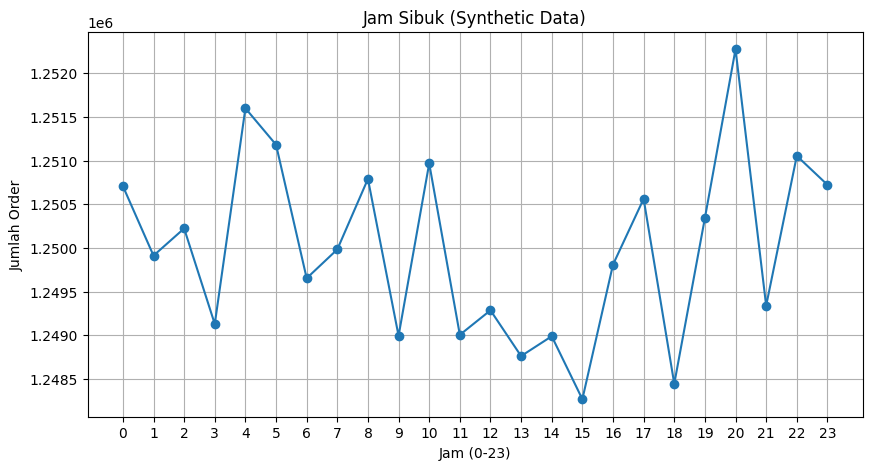

In [11]:
#@title Plot jam sibuk (order created per jam)
import matplotlib.pyplot as plt

# We take a sample to plot quickly, or aggregate using Dask first
orders_by_hour = trip_fact.groupby("hour")["order_id"].count().compute().sort_index()

plt.figure(figsize=(10,5))
orders_by_hour.plot(kind='line', marker='o')
plt.xticks(range(0,24))
plt.xlabel("Jam (0-23)")
plt.ylabel("Jumlah Order")
plt.title("Jam Sibuk (Synthetic Data)")
plt.grid(True)
plt.show()

In [16]:
import folium
from folium.plugins import HeatMap


print("Generating Heatmap (Sample 10k)...")

sample_locs = trip_fact[["pickup_lat", "pickup_lon"]].head(10000)
center_lat = sample_locs["pickup_lat"].mean()
center_lon = sample_locs["pickup_lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

heat_data = [[row.pickup_lat, row.pickup_lon] for row in sample_locs.itertuples()]
HeatMap(heat_data, radius=10, blur=15).add_to(m)

m

Generating Heatmap (Sample 10k)...


#Analitik Fraud/Anomaly Sederhana
Contoh ide:
- driver dengan **cancel_rate** tinggi
- lonjakan **error/latency** pada service tertentu

In [15]:
#@title Driver berisiko (cancel_rate tinggi) + Log anomaly

print("Top Risky Drivers:")
risky_drivers = driver_dim.sort_values("cancel_rate", ascending=False).head(5)
print(risky_drivers[["driver_id", "total_orders", "cancel_rate"]])

print("\nLog Service Stats:")
logs_dd = dd.read_parquet(raw_logs_path)
logs_dd["is_error"] = (logs_dd["error_code"] != "NONE")

svc_stats = logs_dd.groupby("service").agg({
    "service": "count",
    "is_error": "mean",
    "latency_ms": "mean"
}).compute()

svc_stats.columns = ["req_count", "error_rate", "avg_latency"]
svc_stats.sort_values("error_rate", ascending=False)

Top Risky Drivers:
       driver_id  total_orders  cancel_rate
11331      24650           614     0.179153
24854      27570           609     0.174056
36538      45258           622     0.173633
47508       7134           588     0.173469
15902       1451           601     0.171381

Log Service Stats:


,req_count,error_rate,avg_latency
service,,,
rating,7996110,0.150244,99.507360
maps,7999321,0.149965,99.545728
dispatch,8004884,0.149952,99.456747
payment,8001766,0.149923,99.489023
order-service,7997919,0.149885,99.533467
